In [ ]:
# Some tests that calculate known geometric quantities

# restart the kernel to clear past work
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [23]:
# load the required python modules
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint
import time
import sys
import random
import matplotlib.pyplot as plt
%matplotlib inline

# homemade code
sys.path.append('../')
from source.mytests import *                   # go here to change the test conditions
from source.Grid import *

# Input parameters for grid and evolution here
max_r = 9.0
num_points = 106
log_factor = 1.0
my_grid = Grid(max_r, num_points, log_factor)
N = my_grid.num_points_r

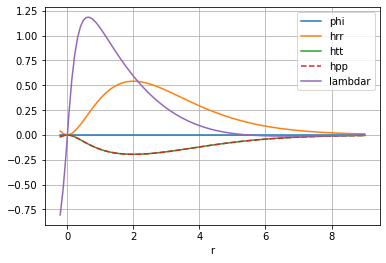

In [24]:
# This test sets up values such that R is known but phi = 0
initial_state = get_test_state_1(my_grid)

#unpackage the vector for readability
u, v , phi, hrr, htt, hpp, K, arr, att, app, lambdar, shiftr, br, lapse = np.array_split(initial_state, NUM_VARS)

#plot initial conditions
plt.xlabel('r')
r = my_grid.r_vector
plt.plot(r, phi, label='phi')
plt.plot(r, hrr, label='hrr')
plt.plot(r, htt, label='htt')
plt.plot(r, hpp, '--', label='hpp')
plt.plot(r, lambdar, label='lambdar')
plt.legend(loc='best')
plt.grid()

In [25]:
print(r,lambdar)

[-0.2195122  -0.13170732 -0.04390244  0.04390244  0.13170732  0.2195122
  0.30731707  0.39512195  0.48292683  0.57073171  0.65853659  0.74634146
  0.83414634  0.92195122  1.0097561   1.09756098  1.18536585  1.27317073
  1.36097561  1.44878049  1.53658537  1.62439024  1.71219512  1.8
  1.88780488  1.97560976  2.06341463  2.15121951  2.23902439  2.32682927
  2.41463415  2.50243902  2.5902439   2.67804878  2.76585366  2.85365854
  2.94146341  3.02926829  3.11707317  3.20487805  3.29268293  3.3804878
  3.46829268  3.55609756  3.64390244  3.73170732  3.8195122   3.90731707
  3.99512195  4.08292683  4.17073171  4.25853659  4.34634146  4.43414634
  4.52195122  4.6097561   4.69756098  4.78536585  4.87317073  4.96097561
  5.04878049  5.13658537  5.22439024  5.31219512  5.4         5.48780488
  5.57560976  5.66341463  5.75121951  5.83902439  5.92682927  6.01463415
  6.10243902  6.1902439   6.27804878  6.36585366  6.45365854  6.54146341
  6.62926829  6.71707317  6.80487805  6.89268293  6.9804878 

In [26]:
# calculate the diagnostics, the Ham constraint should just have 
# the term in bar_R so this tests the calculation of that quantity

# get the various derivs that we need to evolve things in vector form
# second derivatives
d2phidx2    = np.dot(my_grid.derivatives.d2_matrix, phi   )
d2hrrdx2    = np.dot(my_grid.derivatives.d2_matrix, hrr   )
d2httdx2    = np.dot(my_grid.derivatives.d2_matrix, htt   )
d2hppdx2    = np.dot(my_grid.derivatives.d2_matrix, hpp   )
d2lapsedx2  = np.dot(my_grid.derivatives.d2_matrix, lapse )
d2shiftrdx2 = np.dot(my_grid.derivatives.d2_matrix, shiftr)
    
# first derivatives
dphidx     = np.dot(my_grid.derivatives.d1_matrix, phi    )
dhrrdx     = np.dot(my_grid.derivatives.d1_matrix, hrr    )
dhttdx     = np.dot(my_grid.derivatives.d1_matrix, htt    )
dhppdx     = np.dot(my_grid.derivatives.d1_matrix, hpp    )
darrdx     = np.dot(my_grid.derivatives.d1_matrix, arr    )
dattdx     = np.dot(my_grid.derivatives.d1_matrix, att    )
dappdx     = np.dot(my_grid.derivatives.d1_matrix, app    )
dKdx       = np.dot(my_grid.derivatives.d1_matrix, K      )
dlambdardx = np.dot(my_grid.derivatives.d1_matrix, lambdar)
dshiftrdx  = np.dot(my_grid.derivatives.d1_matrix, shiftr )
dbrdx      = np.dot(my_grid.derivatives.d1_matrix, br     )
dlapsedx   = np.dot(my_grid.derivatives.d1_matrix, lapse  )

bar_R_test = np.zeros_like(phi)
chris_rrr  = np.zeros_like(phi)
chris_ttr  = np.zeros_like(phi)
chris_ppr  = np.zeros_like(phi)
Ricci_rr   = np.zeros_like(phi)
Ricci_tt   = np.zeros_like(phi)
Ricci_pp   = np.zeros_like(phi)

h_tensor = np.array([hrr, htt, hpp])
a_tensor = np.array([arr, att, app])
em4phi = np.exp(-4.0*phi)
dhdr   = np.array([dhrrdx, dhttdx, dhppdx])
d2hdr2 = np.array([d2hrrdx2, d2httdx2, d2hppdx2])
    
# Calculate some useful quantities
########################################################

# \hat \Gamma^i_jk
flat_chris = get_flat_spherical_chris(r)

# (unscaled) \bar\gamma_ij and \bar\gamma^ij
bar_gamma_LL = get_metric(r, h_tensor)
bar_gamma_UU = get_inverse_metric(r, h_tensor)

# The connections Delta^i, Delta^i_jk and Delta_ijk
Delta_U, Delta_ULL, Delta_LLL  = get_connection(r, bar_gamma_UU, bar_gamma_LL, h_tensor, dhdr)
    
conformal_chris = get_conformal_chris(Delta_ULL, r)  
chris_rrr = conformal_chris[i_r][i_r][i_r][:]
chris_ttr = conformal_chris[i_t][i_t][i_r][:]
chris_ppr = conformal_chris[i_p][i_p][i_r][:] 
    
bar_Rij = get_ricci_tensor(r, h_tensor, dhdr, d2hdr2, lambdar, dlambdardx, 
                           Delta_U, Delta_ULL, Delta_LLL, bar_gamma_UU, bar_gamma_LL)
            
Ricci_rr = bar_Rij[i_r][i_r]
Ricci_tt = bar_Rij[i_t][i_t]
Ricci_pp = bar_Rij[i_p][i_p]

bar_Ricci_tensor = np.array([Ricci_rr,Ricci_tt,Ricci_pp])
bar_R_test = get_trace(bar_Ricci_tensor, bar_gamma_UU)

r_diagnostics = r[num_ghosts:(N-num_ghosts)]

In [27]:
# Calculate the rescaled quantities for comparison
########################################################

# rescaled \bar\gamma_ij and \bar\gamma^ij
r_gamma_LL = get_rescaled_metric(h_tensor)
r_gamma_UU = get_rescaled_inverse_metric(h_tensor)
        
# \bar A_ij, \bar A^ij and the trace A_i^i, then Asquared = \bar A_ij \bar A^ij
a_UU = get_a_UU(a_tensor, r_gamma_UU)
traceA   = get_trace_A(a_tensor, r_gamma_UU)
Asquared = get_Asquared(a_tensor, r_gamma_UU)
        
# The rescaled connections Delta^i, Delta^i_jk and Delta_ijk
rDelta_U, rDelta_ULL, rDelta_LLL  = get_rescaled_connection(r, r_gamma_UU, 
                                                                r_gamma_LL, h_tensor, dhdr)
# rescaled \bar \Gamma^i_jk
r_conformal_chris = get_rescaled_conformal_chris(rDelta_ULL, r)
r_chris_rrr = r_conformal_chris[i_r][i_r][i_r][:]
r_chris_ttr = r_conformal_chris[i_t][i_t][i_r][:]
r_chris_ppr = r_conformal_chris[i_p][i_p][i_r][:]

# rescaled Ricci tensor
rbar_Rij = get_rescaled_ricci_tensor(r, h_tensor, dhdr, d2hdr2, lambdar, dlambdardx,
                                         rDelta_U, rDelta_ULL, rDelta_LLL, 
                                         r_gamma_UU, r_gamma_LL)

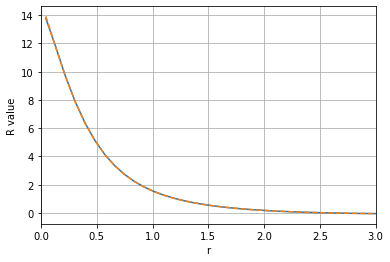

In [28]:
# Plot the Ricci scalar
bar_R_plot = bar_R_test[num_ghosts:(N-num_ghosts)]
plt.plot(r_diagnostics, bar_R_plot)

# compare to analytic result for R for test 1
epowr = np.exp(r_diagnostics)
x = r_diagnostics
tmp = (1.0 + x*x/epowr)**(0.5)
R_analytic = (1.0 / 8.0 / (x*x) * (epowr + x*x)**(-3.0) * 
              (16.0 * (x**6.0) * tmp
               - epowr * (x**4.0) * (-20.0  + 12.0*x + 7.0*x*x - 48.0*tmp)
               + 16.0 * epowr**3.0 * (-1.0 + tmp)
               + 8.0 * epowr**2.0 * x*x * (8.0 - 9.0*x + x*x + 6 * tmp)))

plt.plot(x, R_analytic, '--')

plt.xlabel('r')
plt.ylabel('R value')
plt.xlim(0,3)
#plt.ylim(0,1)
plt.grid()

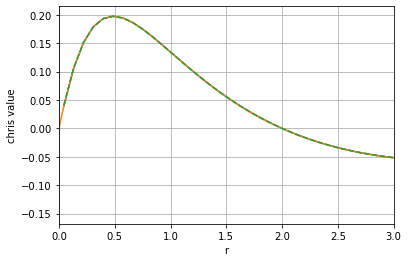

In [29]:
# Plot christoffels
chris_rrr_d = chris_rrr[num_ghosts:(N-num_ghosts)]
plt.plot(r_diagnostics, chris_rrr_d)
plt.plot(r,r_chris_rrr)

# compare to analytic result for R for test 1
epowr = np.exp(r_diagnostics)
x = r_diagnostics
chris_rrr_analytic = -(0.5 * x * (x-2.0) / (epowr + x*x))
plt.plot(x, chris_rrr_analytic, '--')

plt.xlabel('r')
plt.ylabel('chris value')
plt.xlim(0,3)
#plt.ylim(0,1)
plt.grid()

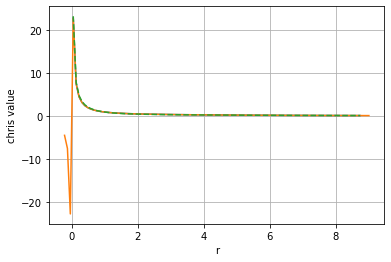

In [30]:
# Plot christoffels
chris_ttr_d = chris_ttr[num_ghosts:(N-num_ghosts)]
plt.plot(r_diagnostics, chris_ttr_d)
plt.plot(r,r_chris_ttr)

# compare to analytic result for R for test 1
epowr = np.exp(r_diagnostics)
x = r_diagnostics
chris_ttr_analytic = (( 4.0 * epowr + 2.0*x + x**3.0 ) / (4.0 * x * epowr + 4.0 * x**3.0))
plt.plot(x, chris_ttr_analytic, '--')
#plt.plot(x, 1.0/x, '--')

plt.xlabel('r')
plt.ylabel('chris value')
#plt.xlim(0,3)
#plt.ylim(-1,1)
plt.grid()

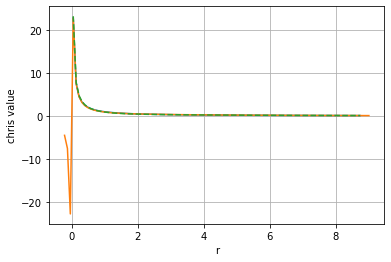

In [40]:
# Plot christoffels
chris_ppr_d = chris_ppr[num_ghosts:(N-num_ghosts)]
plt.plot(r_diagnostics, chris_ppr_d)
plt.plot(r,r_chris_ppr)

# compare to analytic result for R for test 1
epowr = np.exp(r_diagnostics)
x = r_diagnostics
chris_ppr_analytic = chris_ttr_analytic
plt.plot(x, chris_ppr_analytic, '--')

plt.xlabel('r')
plt.ylabel('chris value')
#plt.xlim(0,3)
#plt.ylim(-1,1)
plt.grid()

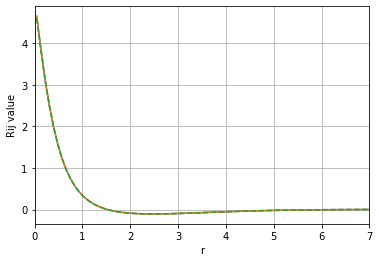

In [32]:
# Plot comps of Ricci - R_rr
Ricci_ij_d = Ricci_rr[num_ghosts:(N-num_ghosts)]
plt.plot(r_diagnostics, Ricci_ij_d)
plt.plot(r, rbar_Rij[i_r][i_r])

# compare to analytic result for R for test 1
epowr = np.exp(r_diagnostics)
x = r_diagnostics
Ricci_analytic = ( (1.0/8.0) * (epowr + x*x)**-2.0 
              * ( x*x * (12 - 4.0*x - 3.0*x*x) 
                  + 4.0 * epowr * (10.0 - 8.0*x + x*x)))
plt.plot(x, Ricci_analytic, '--')

plt.xlabel('r')
plt.ylabel('Rij value')
plt.xlim(0,7)
#plt.ylim(0,1)
plt.grid()

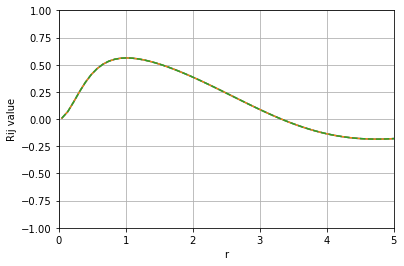

In [33]:
# Plot comps of Ricci - R_tt
Ricci_ij_d = Ricci_tt[num_ghosts:(N-num_ghosts)]
plt.plot(r_diagnostics, Ricci_ij_d)
plt.plot(r_diagnostics, r_diagnostics * r_diagnostics * rbar_Rij[i_t][i_t][num_ghosts:(N-num_ghosts)])

# compare to analytic result for R for test 1
epowr = np.exp(r_diagnostics)
x = r_diagnostics
tmp = (1.0 + x*x/epowr)**(0.5)
Ricci_analytic_tt = ( 0.25 * epowr**2.0 * tmp * ((epowr + x*x)**(-4.0))
                  * ( -4.0 * epowr**2.0 
                     + epowr * x**2.0 * (6.0 -10.0*x +x*x) 
                     - x**4.0 * (-2.0 + 2.0*x + x*x))) + 1.0
plt.plot(x, Ricci_analytic_tt, '--')

plt.xlabel('r')
plt.ylabel('Rij value')
plt.xlim(0,5)
plt.ylim(-1,1)
plt.grid()

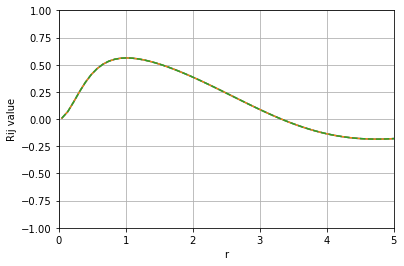

In [34]:
# Plot comps of Ricci - R_pp
Ricci_ij_d = Ricci_pp[num_ghosts:(N-num_ghosts)]
plt.plot(r_diagnostics, Ricci_ij_d)
plt.plot(r_diagnostics, r_diagnostics * r_diagnostics * rbar_Rij[i_p][i_p][num_ghosts:(N-num_ghosts)])

# compare to analytic result for R for test 1
epowr = np.exp(r_diagnostics)
x = r_diagnostics
Ricci_analytic_pp = Ricci_analytic_tt
plt.plot(x, Ricci_analytic_pp, '--')

plt.xlabel('r')
plt.ylabel('Rij value')
plt.xlim(0,5)
plt.ylim(-1,1)
plt.grid()

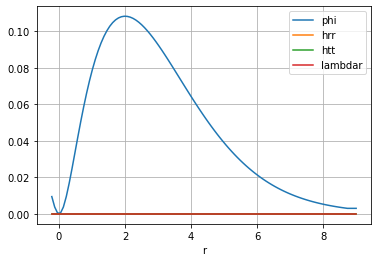

In [35]:
# This test sets up values such that R is known but bar_R = 0
initial_state = get_test_state_2(my_grid)

#unpackage the vector for readability
u, v , phi, hrr, htt, hpp, K, arr, att, app, lambdar, shiftr, br, lapse = np.array_split(initial_state, NUM_VARS)

#plot initial conditions
plt.xlabel('r')
plt.plot(r, phi, label='phi')
plt.plot(r, hrr, label='hrr')
plt.plot(r, htt, label='htt')
plt.plot(r, lambdar, label='lambdar')
plt.legend(loc='best')
plt.grid()

In [36]:
# get the various derivs that we need to evolve things in vector form
# second derivatives
d2phidx2    = np.dot(my_grid.derivatives.d2_matrix, phi   )
d2hrrdx2    = np.dot(my_grid.derivatives.d2_matrix, hrr   )
d2httdx2    = np.dot(my_grid.derivatives.d2_matrix, htt   )
d2hppdx2    = np.dot(my_grid.derivatives.d2_matrix, hpp   )
d2lapsedx2  = np.dot(my_grid.derivatives.d2_matrix, lapse )
d2shiftrdx2 = np.dot(my_grid.derivatives.d2_matrix, shiftr)
    
# first derivatives
dphidx     = np.dot(my_grid.derivatives.d1_matrix, phi    )
dhrrdx     = np.dot(my_grid.derivatives.d1_matrix, hrr    )
dhttdx     = np.dot(my_grid.derivatives.d1_matrix, htt    )
dhppdx     = np.dot(my_grid.derivatives.d1_matrix, hpp    )
darrdx     = np.dot(my_grid.derivatives.d1_matrix, arr    )
dattdx     = np.dot(my_grid.derivatives.d1_matrix, att    )
dappdx     = np.dot(my_grid.derivatives.d1_matrix, app    )
dKdx       = np.dot(my_grid.derivatives.d1_matrix, K      )
dlambdardx = np.dot(my_grid.derivatives.d1_matrix, lambdar)
dshiftrdx  = np.dot(my_grid.derivatives.d1_matrix, shiftr )
dbrdx      = np.dot(my_grid.derivatives.d1_matrix, br     )
dlapsedx   = np.dot(my_grid.derivatives.d1_matrix, lapse  )

bar_R_test = np.zeros_like(phi)
chris_rrr  = np.zeros_like(phi)
chris_ttr  = np.zeros_like(phi)
chris_ppr  = np.zeros_like(phi)
Ricci_rr   = np.zeros_like(phi)
Ricci_tt   = np.zeros_like(phi)
Ricci_pp   = np.zeros_like(phi)

h_tensor = np.array([hrr, htt, hpp])
a_tensor = np.array([arr, att, app])
em4phi = np.exp(-4.0*phi)
dhdr   = np.array([dhrrdx, dhttdx, dhppdx])
d2hdr2 = np.array([d2hrrdx2, d2httdx2, d2hppdx2])
    
# Calculate some useful quantities
########################################################

# \hat \Gamma^i_jk
flat_chris = get_flat_spherical_chris(r)

# (unscaled) \bar\gamma_ij and \bar\gamma^ij
bar_gamma_LL = get_metric(r, h_tensor)
bar_gamma_UU = get_inverse_metric(r, h_tensor)
    
# The connections Delta^i, Delta^i_jk and Delta_ijk
Delta_U, Delta_ULL, Delta_LLL  = get_connection(r, bar_gamma_UU, bar_gamma_LL, h_tensor, dhdr)
    
conformal_chris = get_conformal_chris(Delta_ULL, r)  
chris_rrr = conformal_chris[i_r][i_r][i_r][:]
chris_ttr = conformal_chris[i_t][i_t][i_r][:]
chris_ppr = conformal_chris[i_p][i_p][i_r][:] 
    
bar_Rij = get_ricci_tensor(r, h_tensor, dhdr, d2hdr2, lambdar, dlambdardx, 
                           Delta_U, Delta_ULL, Delta_LLL, bar_gamma_UU, bar_gamma_LL)
            
Ricci_rr = bar_Rij[i_r][i_r]
Ricci_tt = bar_Rij[i_t][i_t]
Ricci_pp = bar_Rij[i_p][i_p]

bar_Ricci_tensor = np.array([Ricci_rr,Ricci_tt,Ricci_pp])
bar_R_test = get_trace(bar_Ricci_tensor, bar_gamma_UU)

r_diagnostics = r[num_ghosts:(N-num_ghosts)]
    
# Get the Ham constraint eqn (13) of Baumgarte https://arxiv.org/abs/1211.6632
Ham_test = em4phi * ( bar_R_test #should be zero
                           - 8.0 * bar_gamma_UU[i_r][i_r] * (dphidx * dphidx + d2phidx2)
                           # These terms come from \bar\Gamma^r d_r \phi from the \bar D^2 \phi term
                           + 8.0 * bar_gamma_UU[i_t] * dphidx * flat_chris[i_r][i_t][i_t]
                           + 8.0 * bar_gamma_UU[i_p] * dphidx * flat_chris[i_r][i_p][i_p]
                           + 8.0 * Delta_U[i_r] * dphidx) #should be zero

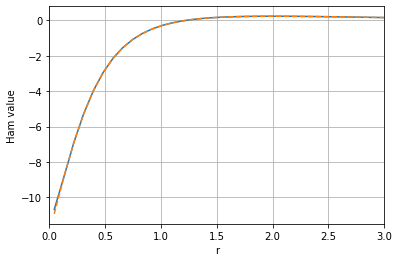

In [37]:
# Plot the result
Ham_plot = Ham_test[num_ghosts:(N-num_ghosts)]
plt.plot(r_diagnostics, Ham_plot)

#analytic result for test 2
epowr = np.exp(r_diagnostics)
x = r_diagnostics
R_analytic = - (0.5 * epowr * (epowr + x*x)**-3.0 
              * ( x*x * (12.0 - 12.0*x + x*x) 
                 + 4.0 * epowr * (6.0 - 6.0* x + x*x)))


plt.plot(x, R_analytic, '--')

plt.xlabel('r')
plt.ylabel('Ham value')
plt.xlim(0,3)
#plt.ylim(-12,1)
plt.grid()